## MOVIE RECOMMENDATION SYSTEM

##### BUSINESS UNDERSTANDING
The goal of this project is to build a recommendation system to improve user experience and drive engagement.
This system aims to recommend movies based on user's watch history and preferences.

##### OBJECTIVES
The key business goals are as follows:
1. To improve customer experience and satisfaction by providing personalized recommendations according to user preference, leading to increased engagements.
2. To increase user retention by keeping users active and engaged by suggesting movies that align with their intersts therefore reducing customer churn rates.
3. Driving revenue through targeted advertising and premium content subscription.
4. To introduce users to new movies they might not have considered.
5. To provide insights on user behavior and preferences to inform future content development and marketing strategies.

##### DATA UNDERSTANDING
The data used is from https://grouplens.org/datasets/movielens/latest/. This dataset is from the GroupLens Research laboratory from the University of Minesota.
The dataset contains the following information:
1. Links.csv with these columns: movieId, imdbId and tmdbId
2. Movies.csv with these columns: movieId, title and genres
3. tags.csv with these columns: userId, movieId, tag and timestamp
4. rating.csv with these columns: userId, movieId ,rating and timestamp


#### LOADING THE DATASETS

In [1]:
import pandas as pd

#loading the datasets
movies_df = pd.read_csv(r'C:\Users\hp\Documents\phase4_project\Movie-Recommendation-System-Group_12-Project\Data\ml-latest-small\movies.csv')
links = pd.read_csv(r'C:\Users\hp\Documents\phase4_project\Movie-Recommendation-System-Group_12-Project\Data\ml-latest-small\links.csv')
ratings = pd.read_csv(r'C:\Users\hp\Documents\phase4_project\Movie-Recommendation-System-Group_12-Project\Data\ml-latest-small\ratings.csv')
tags = pd.read_csv(r'C:\Users\hp\Documents\phase4_project\Movie-Recommendation-System-Group_12-Project\Data\ml-latest-small\tags.csv')


In [2]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [5]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


#### INSPECTING THE DATASET FOR ANY MISSING VALUES AND DUPLICATES
Checking for missing values in the dataset

In [6]:
print(movies_df.isnull().sum())
print(ratings.isnull().sum())
print(tags.isnull().sum())
print(links.isnull().sum())

movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64
movieId    0
imdbId     0
tmdbId     8
dtype: int64


From the code above we can see that the dataset is fairly clean so we can check for any duplicate rows and drop them

In [7]:
print(movies_df.duplicated().sum())
print(ratings.duplicated().sum())
print(tags.duplicated().sum())
print(links.duplicated().sum())

0
0
0
0


The dataset has no duplicates.

### EXPLORATORY DATA ANALYSIS
This is to:
1. Identify patterns in user interactions.
2. Understand sparsity in user-item matrices.
3. Visualize distributions (e.g., ratings distributions, most popular items)

In [8]:
#loading the necessary libraries
import matplotlib.pyplot as plt   
import seaborn as sns

### DISTRIBUTION OF RATINGS

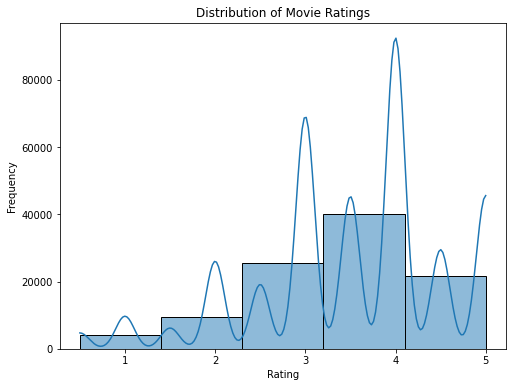

In [9]:
plt.figure(figsize=(8, 6))
sns.histplot(ratings['rating'], bins=5, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

#### NUMBER RATINGS PER MOVIES
Visualizing the top 10 rated movies

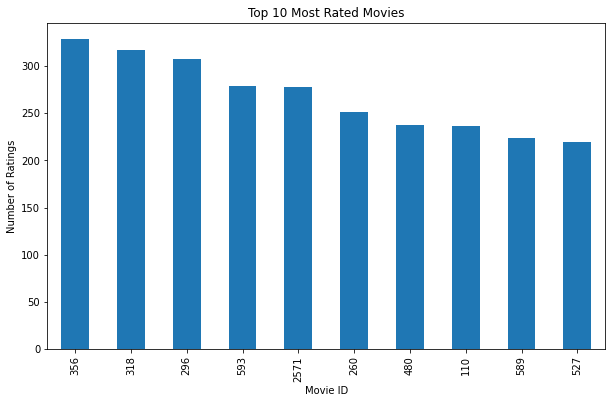

In [10]:
# Number of ratings per movie
ratings_per_movie = ratings.groupby('movieId')['rating'].count().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ratings_per_movie.head(10).plot(kind='bar')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Movie ID')
plt.ylabel('Number of Ratings')
plt.show()


#### NUMBER OF USERS PER RATING

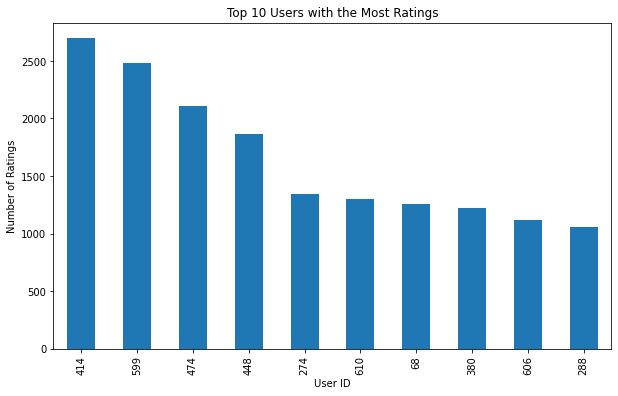

In [11]:
# Number of ratings per user
ratings_per_user = ratings.groupby('userId')['rating'].count().sort_values(ascending=False)

# Plot the top 10 users with the most ratings
plt.figure(figsize=(10, 6))
ratings_per_user.head(10).plot(kind='bar')
plt.title('Top 10 Users with the Most Ratings')
plt.xlabel('User ID')
plt.ylabel('Number of Ratings')
plt.show()


#### AVERAGE RATINGS PER MOVIE

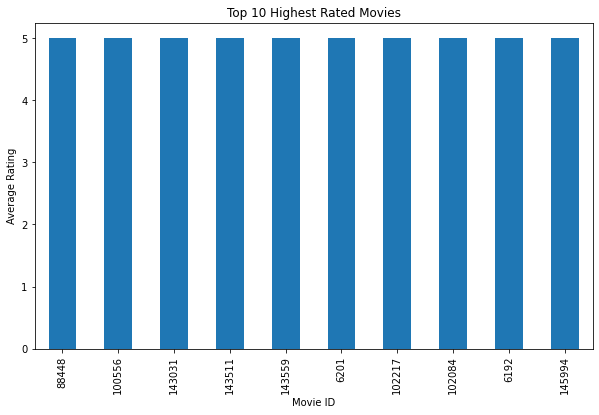

In [12]:
# Average rating per movie
average_ratings = ratings.groupby('movieId')['rating'].mean().sort_values(ascending=False)

# Plot the top 10 highest-rated movies
plt.figure(figsize=(10, 6))
average_ratings.head(10).plot(kind='bar')
plt.title('Top 10 Highest Rated Movies')
plt.xlabel('Movie ID')
plt.ylabel('Average Rating')
plt.show()


##### CORRELATION BETWEEN NUMBER OF RATINGS AND AVERAGE RATINGS

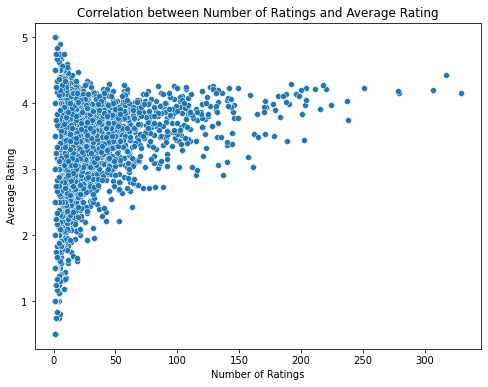

In [13]:
# Create a new dataframe with movie_id, number of ratings, and average rating
movie_stats = ratings.groupby('movieId').agg({'rating': ['mean', 'count']})
movie_stats.columns = ['avg_rating', 'num_ratings']

# Plot correlation
plt.figure(figsize=(8, 6))
sns.scatterplot(x='num_ratings', y='avg_rating', data=movie_stats)
plt.title('Correlation between Number of Ratings and Average Rating')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.show()


#### DATA PREPROCESSING
##### 1. Preprocessing the movie dataset

In [14]:
# One-hot encode genres for content-based filtering
movies_df['genres'] = movies_df['genres'].str.split('|')
movies_genres = movies_df['genres'].str.join('|').str.get_dummies()

# Combine movies and genres data
movies = pd.concat([movies_df[['movieId', 'title']], movies_genres], axis=1)

# Preprocess tags (merge tags for the same movie)
tags_grouped = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()

# Merge tags with movies dataframe
movies = pd.merge(movies, tags_grouped, on='movieId', how='left')


#### MODELLING
##### COLLABORATIVE FILTERING SYSTEM

In [15]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

# Load data for Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Train-Test split
trainset, testset = train_test_split(data, test_size=0.2)

# Use SVD model
svd = SVD()

# Train the model
svd.fit(trainset)

# Make predictions and evaluate RMSE
predictions = svd.test(testset)
accuracy.rmse(predictions)


RMSE: 0.8793


0.8793058228094678

#### Recommending movies based on Collaborative system

In [16]:
def recommend_movies_for_user(userId, num_recommendations=10):
    # Get a list of all movie IDs
    all_movie_ids = movies['movieId'].unique()
    
    # Get the list of movies already rated by the user
    rated_movies = ratings[ratings['userId'] == userId]['movieId'].unique()
    
    # Filter out movies the user has already rated
    unrated_movies = [movie for movie in all_movie_ids if movie not in rated_movies]
    
    # Predict ratings for unrated movies
    predictions = [svd.predict(userId, movieId) for movieId in unrated_movies]
    
    # Sort predictions by estimated rating
    top_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:num_recommendations]
    
    # Get movie titles for the recommended movies
    recommended_movie_ids = [pred.iid for pred in top_predictions]
    recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]
    
    return recommended_movies[['title']]


#### Content-Based Filtering
For content-based filtering, we use movie genres and tags to recommend similar movies to what a user has watched.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Vectorize tags using TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['tag'].fillna(''))

# Compute cosine similarity between movies based on tags
cosine_sim_tags = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Compute similarity based on genres
cosine_sim_genres = cosine_similarity(movies_genres, movies_genres)

# Combine both cosine similarities
cosine_sim_combined = (cosine_sim_tags + cosine_sim_genres) / 2

# Function to recommend similar movies based on content
def recommend_movies_based_on_content(movie_title, num_recommendations=10):
    idx = movies[movies['title'] == movie_title].index[0]
    
    # Get similarity scores
    sim_scores = list(enumerate(cosine_sim_combined[idx]))
    
    # Sort movies by similarity score
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get indices of the top similar movies
    movie_indices = [i[0] for i in sim_scores[1:num_recommendations+1]]
    
    return movies[['title']].iloc[movie_indices]


#### HYBRID MODEL: COMBINNG BOTH SVD AND CONTENT BASED-FILTERING

In [18]:
import numpy as np

def hybrid_recommendation(userId, movie_title, num_recommendations=10):
    #Get collaborative filtering recommendations using SVD
    all_movie_ids = movies['movieId'].unique()
    
    #list of movies already rated by the user
    rated_movies = ratings[ratings['userId'] == userId]['movieId'].unique()
    
    # Filter out movies the user has already rated
    unrated_movies = [movie for movie in all_movie_ids if movie not in rated_movies]
    
    # Predict ratings for unrated movies using SVD
    predictions = [svd.predict(userId, movieId) for movieId in unrated_movies]
    predicted_ratings = {pred.iid: pred.est for pred in predictions}
    
   #Get content-based recommendations
    idx = movies[movies['title'] == movie_title].index[0]
    sim_scores = list(enumerate(cosine_sim_combined[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get similarity scores for all unrated movies
    content_scores = {movies.iloc[i[0]]['movieId']: i[1] for i in sim_scores if movies.iloc[i[0]]['movieId'] in unrated_movies}

    # Normalize both scores before combining
    max_pred = max(predicted_ratings.values())
    min_pred = min(predicted_ratings.values())
    
    for movieId in predicted_ratings:
        predicted_ratings[movieId] = (predicted_ratings[movieId] - min_pred) / (max_pred - min_pred)
    
    max_sim = max(content_scores.values())
    min_sim = min(content_scores.values())
    
    for movieId in content_scores:
        content_scores[movieId] = (content_scores[movieId] - min_sim) / (max_sim - min_sim)
    
    # Combine the scores using a weighted sum
    hybrid_scores = {movieId: 0.5 * predicted_ratings.get(movieId, 0) + 0.5 * content_scores.get(movieId, 0)
                     for movieId in unrated_movies}
    
    # Recommend top N movies
    top_movies = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)[:num_recommendations]
    
    recommended_movie_ids = [movie[0] for movie in top_movies]
    return movies[movies['movieId'].isin(recommended_movie_ids)][['title']]


In [19]:
def recommend_popular_movies(num_recommendations=10):
    popular_movies = ratings.groupby('movieId')['rating'].mean().sort_values(ascending=False)
    popular_movie_ids = popular_movies.index[:num_recommendations]
    
    return movies[movies['movieId'].isin(popular_movie_ids)][['title']]


In [20]:
# Example usage:
recommendations = hybrid_recommendation(userId=1, movie_title="Return to Oz (1985)", num_recommendations=10)
print(recommendations)

                                                  title
2355                                 Toy Story 2 (1999)
3574  Harry Potter and the Sorcerer's Stone (a.k.a. ...
3638  Lord of the Rings: The Fellowship of the Ring,...
4137      Lord of the Rings: The Two Towers, The (2002)
6014                                  MirrorMask (2005)
6075  Chronicles of Narnia: The Lion, the Witch and ...
6944                 Ponyo (Gake no ue no Ponyo) (2008)
7478  Chronicles of Narnia: The Voyage of the Dawn T...
8719                 The Cave of the Golden Rose (1991)
9565                          Gulliver's Travels (1996)


#### Cold-Start Problem (Recommendations for New Users)
We recommend movies based on popularity of thr movies

In [21]:
def recommend_popular_movies(num_recommendations=10):
    popular_movies = ratings.groupby('movieId')['rating'].mean().sort_values(ascending=False)
    popular_movie_ids = popular_movies.index[:num_recommendations]
    
    return movies[movies['movieId'].isin(popular_movie_ids)][['title']]


Improving the cold start problem by implementing a system that can recommend both popular movies and highly rated movies for new user

In [22]:
def hybrid_recommendation_for_new_user(movie_title, num_recommendations=10):
    #content-based recommendations using the given movie title
    idx = movies[movies['title'] == movie_title].index[0]
    sim_scores = list(enumerate(cosine_sim_combined[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    #top N similar movies
    movie_indices = [i[0] for i in sim_scores[1:num_recommendations+1]]
    recommended_movies = movies[['title']].iloc[movie_indices]
    
    #Recommend popular movies as backup (in case no content-based data is available)
    popular_movies = recommend_popular_movies(num_recommendations - len(recommended_movies))
    
    return pd.concat([recommended_movies, popular_movies])


In [23]:
# Example usage for a new user:
new_user_recommendations = hybrid_recommendation_for_new_user(movie_title="Jumanji (1995)", num_recommendations=10)
print(new_user_recommendations)

                                                  title
3574  Harry Potter and the Sorcerer's Stone (a.k.a. ...
6751   Chronicles of Narnia: Prince Caspian, The (2008)
3638  Lord of the Rings: The Fellowship of the Ring,...
4076     Harry Potter and the Chamber of Secrets (2002)
53                   Indian in the Cupboard, The (1995)
109                   NeverEnding Story III, The (1994)
767                     Escape to Witch Mountain (1975)
1514          Darby O'Gill and the Little People (1959)
1556                                Return to Oz (1985)
1617                      NeverEnding Story, The (1984)


#### NUERAL NETWORKS

In [24]:
#importing the necessary libraries
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam

Encoding the userId and movieId to integer

In [25]:

# Label Encoding userId and movieId
encoder = LabelEncoder()

tags['userId'] = encoder.fit_transform(tags['userId'])
tags['movieId'] = encoder.fit_transform(tags['movieId'])
tags['tag'] = encoder.fit_transform(tags['tag'])

Splitting data into train and test sets

In [26]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(tags, test_size=0.3, random_state=42)


Here, we define the model. It learns user and movie embeddings, which are concatenated and passed through a dense neural network to predict interaction.

In [27]:
# Set the size of embeddings (latent factors)
n_users = tags['userId'].nunique()
n_movies = tags['movieId'].nunique()
n_tags = ratings['rating'].nunique()

embedding_size = 50  # Number of latent factors

# Input layers
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')

# Embedding layers
user_embedding = Embedding(input_dim=n_users, output_dim=embedding_size, name='user_embedding')(user_input)
movie_embedding = Embedding(input_dim=n_movies, output_dim=embedding_size, name='movie_embedding')(movie_input)

# Flatten the embeddings
user_vec = Flatten()(user_embedding)
movie_vec = Flatten()(movie_embedding)

# Concatenate user and movie embeddings
concatenated = Concatenate()([user_vec, movie_vec])

# Add fully connected layers
fc1 = Dense(128, activation='relu')(concatenated)
dropout1 = Dropout(0.3)(fc1)
fc2 = Dense(64, activation='relu')(dropout1)
dropout2 = Dropout(0.3)(fc2)

# Output layer (Regression task: predict the rating or sentiment score)
output = Dense(1, activation='linear')(dropout2)

# Build the model
model = Model([user_input, movie_input], output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


In [28]:
#training the model
X_train_user = train_data['userId'].values
X_train_movie = train_data['movieId'].values
y_train = train_data['tag'].values

#fitting the model
history = model.fit(
    [X_train_user, X_train_movie],
    y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)



Epoch 1/10
33/33 [==============================] - 2s 13ms/step - loss: 894729.9375 - val_loss: 949272.6875
Epoch 2/10
33/33 [==============================] - 0s 6ms/step - loss: 883976.6250 - val_loss: 918874.3125
Epoch 3/10
33/33 [==============================] - 0s 5ms/step - loss: 799434.8125 - val_loss: 746324.4375
Epoch 4/10
33/33 [==============================] - 0s 5ms/step - loss: 511954.0000 - val_loss: 370551.6250
Epoch 5/10
33/33 [==============================] - 0s 4ms/step - loss: 237973.6562 - val_loss: 246232.5938
Epoch 6/10
33/33 [==============================] - 0s 5ms/step - loss: 199155.8281 - val_loss: 239995.2500
Epoch 7/10
33/33 [==============================] - 0s 5ms/step - loss: 176573.2031 - val_loss: 236058.0781
Epoch 8/10
33/33 [==============================] - 0s 4ms/step - loss: 163894.6406 - val_loss: 237108.9531
Epoch 9/10
33/33 [==============================] - 0s 4ms/step - loss: 147727.0156 - val_loss: 240069.7344
Epoch 10/10
33/33 [========

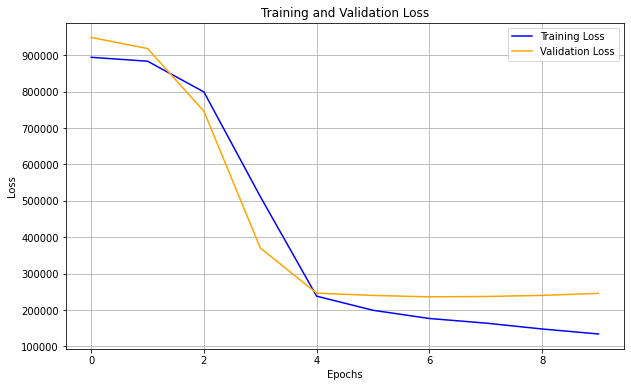

In [29]:

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

##### COMPARISON BETWEEN TRAIN LOSS AND TEST LOSS
The Test Loss is 213621.890625, and it represents the performance of the model on testing data, this is data the model hasn't seen
Train Loss: 137401.328125 represents the performance of the model on training data
The disparity in the two losses represents possible overfitting. The model is performing well on the train data but poorly on the test data.